# HelioCloud Storage + Burst + SDO

* HelioCloud is an AWS Cloud environment that is user-friendly
* Daskhub is a cloud Notebooks setup that allows parallel processing via Dask
* Dask lets you temporarily throw lots of CPUs at a problem
* S3 is the big cheap AWS storage
* SDO is a mission with lots of image data

Here we combine a few HelioCloud demos with our big data fileRegistry to tackle 1 year of SDO data.  The data is in AWS S3 and we do not copy the files over, but instead have CPUs at AWS access it directly

* 1 year of SDO 94A EUV images from AIA is 129,758 files, each 14MB, totalling 1.8 TB.
* This code calculates a simple irradiance
* If done serially on your laptop, it would take 27 hours
* HelioCloud takes 25 minutes (1467 sec) to analyze through 1 year of SDO data

(More fun stats: that's 88 files/second, also 1 GB/sec to do the full analysis (which is 2x the read speed of a SATA SSD.  It is 2x faster than it would take to just copy the files off a local disk and 8x faster than copying via gigabit internet).


In [1]:
import scregistry_prerelease as scregistry
import boto3
import dask
import io
import logging
import time
import re
import pickle
import astropy.io.fits
from dask.distributed import Client
from dask_gateway import Gateway, GatewayCluster

# HelioCloud shared cloud file registry (scregistry)

This is a simple standard for any dataset that enables users to access it via an API or directly.  The short definition is:
    * S3 disks have a 'catalog.json' describing their datasets
    * Each dataset has a <dataid>_YYYY.csv index file of its contents
    * These indexes have the form "time, s3_location, filesize" (plus optional metadata)
    
Let's walk through this.

# List of all known 'catalogs'

In [2]:
# this is pre-release so the main registry is on a temporary site
cr=scregistry.CatalogRegistry("http://ghostlibrary.com/HelioDataRegistry.json")

# Let us see which clouds are known to the HelioCloud network
cat = cr.get_catalog()
print("List of clouds via get_catalog",cat,'\n')
reg = cr.get_registry()
print("Or just the S3 endpoints via get_registry:",reg,'\n')
link = cr.get_entries()
print("get_entries:",link,'\n')

# Now let us grab the specific cloud containing SDO
url = cr.get_endpoint("HelioCloud, including SDO")
print("SDO result for get_endpoint:",url)

List of clouds via get_catalog {'CloudMe': '0.1', 'modificationDate': '2022-01-01T00:00Z', 'registry': [{'endpoint': 's3://helio-public/', 'name': 'GSFC HelioCloud Public Temp', 'region': 'us-east-1'}, {'endpoint': 's3://gov-nasa-hdrl-data1/', 'name': 'HelioCloud, including SDO', 'region': 'us-east-1'}]} 

Or just the S3 endpoints via get_registry: [{'endpoint': 's3://helio-public/', 'name': 'GSFC HelioCloud Public Temp', 'region': 'us-east-1'}, {'endpoint': 's3://gov-nasa-hdrl-data1/', 'name': 'HelioCloud, including SDO', 'region': 'us-east-1'}] 

get_entries: [('GSFC HelioCloud Public Temp', 'us-east-1'), ('HelioCloud, including SDO', 'us-east-1')] 

SDO result for get_endpoint: s3://gov-nasa-hdrl-data1/


# For a given S3 location, list of all available datasets

In [3]:
fr=scregistry.FileRegistry("s3://gov-nasa-hdrl-data1/")
print("All datasets at this HDRL S3:\n",fr.get_entries())

All datasets at this HDRL S3:
 [('aia_0094', 'AIA 0094 FITS data'), ('aia_0131', 'AIA 0131 FITS data'), ('aia_0171', 'AIA 0171 FITS data'), ('aia_0193', 'AIA 0193 FITS data'), ('aia_0211', 'AIA 0211 FITS data'), ('aia_0304', 'AIA 0304 FITS data'), ('aia_0335', 'AIA 0335 FITS data'), ('aia_1600', 'AIA 1600 FITS data'), ('aia_1700', 'AIA 1700 FITS data'), ('LatLonVMu', 'LatLonVMu FITS data'), ('hmi_B', 'HMI B FITS data'), ('hmi_Ic', 'HMI Ic FITS data'), ('hmi_Ic_noLimbDark', 'HMI Ic_noLimbDark FITS data'), ('hmi_M', 'HMI M FITS data'), ('hmi_V', 'HMI V FITS data')]


In [4]:
# Now we get metadata associated with AIA 94A
frID = "aia_0094"
myjson = fr.get_entry(frID)
start, stop = myjson['startDate'], myjson['stopDate']
print(frID,start,stop)

aia_0094 2010-05-13T00:00:00Z 2022-12-31T23:56:00Z


# Optionally you can choose a subsetted time range (faster testing)

In [5]:
subset = True
if subset: start, stop = '2020-01-01T00:00:00Z', '2020-12-31T23:59:59Z'

# Now let us get the entire list of SDO files for that AIA ID

In [6]:
file_registry1 = fr.request_file_registry(frID, start_date=start, stop_date=stop, overwrite=False)
# And convert that richer data to a list of files to process
filelist = file_registry1['key'].to_list()

In [7]:
file_registry1

,startDate,key,filesize
0,2020-02-17 00:00:00,s3://gov-nasa-hdrl-data1/sdo/aia/20200217/0094...,13910400
1,2020-02-17 00:04:00,s3://gov-nasa-hdrl-data1/sdo/aia/20200217/0094...,13910400
2,2020-02-17 00:08:00,s3://gov-nasa-hdrl-data1/sdo/aia/20200217/0094...,13910400
3,2020-02-17 00:12:00,s3://gov-nasa-hdrl-data1/sdo/aia/20200217/0094...,13910400
4,2020-02-17 00:16:00,s3://gov-nasa-hdrl-data1/sdo/aia/20200217/0094...,13910400
...,...,...,...
129753,2020-02-16 23:40:00,s3://gov-nasa-hdrl-data1/sdo/aia/20200216/0094...,13913280
129754,2020-02-16 23:44:00,s3://gov-nasa-hdrl-data1/sdo/aia/20200216/0094...,13910400
129755,2020-02-16 23:48:00,s3://gov-nasa-hdrl-data1/sdo/aia/20200216/0094...,13910400
129756,2020-02-16 23:52:00,s3://gov-nasa-hdrl-data1/sdo/aia/20200216/0094...,13913280


# Actual Analysis code

Here's our analysis routines, that operate on a single FITS file and returns the results of our 'work_on_data()' function.

In [8]:
def DO_SCIENCE(mydata):
    # you can put better science here
    iirad = mydata.mean()
    return iirad

# these are variable helpful handler functions
def s3url_to_bucketkey(s3url: str): # -> Tuple[str, str]:
    """
    Extracts the S3 bucket name and file key from an S3 URL.
    e.g. s3://mybucket/mykeypart1/mykeypart2/fname.fits -> mybucket, mykeypart1/mykeypart2/fname.fits
    """
    name2 = re.sub(r"s3://","",s3url)
    s = name2.split("/",1)
    return s[0], s[1]

def process_fits_s3(s3key:str): # -> Tuple[str, float]:
    """ For a single FITS file, read it from S3, grab the header and
        data, then do the DO_SCIENCE() call of choice
    """
    sess = boto3.session.Session() # do this each open to avoid thread problem 'credential_provider'
    s3c = sess.client("s3")
    mybucket,mykey = s3url_to_bucketkey(s3key)
    try:
        fobj = s3c.get_object(Bucket=mybucket,Key=mykey)
        rawdata = fobj['Body'].read()
        bdata = io.BytesIO(rawdata)
        hdul = astropy.io.fits.open(bdata,memmap=False)        
        date = hdul[1].header['T_OBS']
        irrad = DO_SCIENCE(hdul[1].data)
    except:
        print("Error fetching ",s3key)
        date, irrad = None, None
        
    return date, irrad


# Accessing S3 from anywhere
The power of cloud is moving compute (CPUs) to the data, instead of hauling data over internet.  But if you want to play, here is a serial example of fetching the first 10 SDO files and processing them anywhere.  It is serial and slow-- roughly 66x slower than using parallel processing and 128x or more slow if you are fetching from S3 to your local machine.

In [9]:
# Serial test it on the first ten files, so slow
now=time.time()
for i in range(10):
    results = process_fits_s3(filelist[i])
    print(results)
print(time.time()-now)

('2020-02-17T00:00:00.572', 1.14938653)
('2020-02-17T00:04:00.566', 1.14467738)
('2020-02-17T00:08:00.565', 1.14912166)
('2020-02-17T00:12:00.581', 1.15062206)
('2020-02-17T00:16:00.565', 1.15031615)
('2020-02-17T00:20:00.566', 1.14179095)
('2020-02-17T00:24:00.588', 1.14150782)
('2020-02-17T00:28:00.572', 1.14470468)
('2020-02-17T00:32:00.588', 1.15231304)
('2020-02-17T00:36:00.572', 1.14333933)
9.758683204650879


# Setting up the Dask 'burst' Configuration
This is pretty standard daskhub configuration from the HelioCloud dask demos, that works to burst tasks into the cloud.

In [10]:
testing = True
if testing:
    s3_files = filelist[0:10000] # small test set to test
else:
    s3_files = filelist
print(len(s3_files))

10000


In [11]:
# number of workers to use, for automatic scaling, our max number
n_workers = 50 # 10-50 works well, more workers actually went slower
# memory per worker (in Gb), typically 1, 2 or 4GB
w_memory = 4
# cores per worker, must be 1-4
w_cores = 4
# use Manual (if False, then uses Automatic scaling)
use_manual_scaling = False

useGUI = False # set true if you want the Dask widget as well

In [12]:
# from the daskhub tutorial, setting up dask
gateway = Gateway()
options = gateway.cluster_options()
options.worker_cores = w_cores
options.worker_memory = w_memory

In [13]:
# initialize cluster and create client, takes < 15 seconds

cluster = gateway.new_cluster(options)
client = cluster.get_client() # can also use 'client=Client(cluster)'
cluster.adapt(minimum=1, maximum=n_workers)

# This calls the widget
if useGUI: cluster

In [14]:
client # let us take a look at it

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/daskhub.ac16bbff01f9401bb3f4affd5708ce28/status,


# Now the actual algorithm work and runtime

In this case, our earlier 'file_registry1' is our set of fully qualified s3:// objects.  This code takes around 5 minutes for 10,000 files and 25 minutes for the full 130K files.

In [15]:
now=time.time()
# simple version step 1, do it
time_irrad = client.map(process_fits_s3, s3_files)
print(time_irrad[0:4]) # handy way to spot-check that the jobs were sent
# simple version step 2, gather results
all_data = client.gather(time_irrad)
print(time.time()-now, len(all_data))
# always shutdown
cluster.shutdown()

[<Future: pending, key: process_fits_s3-950ee03cb1f2699173660c5bf56970dc>, <Future: pending, key: process_fits_s3-0d3db2e8b22675cf2d98524fdd455ab0>, <Future: pending, key: process_fits_s3-81bf4af06c3e95871209573140e5948c>, <Future: pending, key: process_fits_s3-70a06a0682852a7ffa2740fb15d86ca1>]
146.71624946594238 10000


# Done, now do something with the results
Time to save your results, plot it, and carry on with your analysis.

In [16]:
# let us save this
with open('SDO_test.pickle','wb') as fout:
    pickle.dump(all_data, fout)

In [17]:
# Goodness check-- did any files not process?
a = [a for a in all_data if a[0] is None]
print("Bad fields: ",len(a))
plotme = [a for a in all_data if a[0] is not None]
print("Good fields: ",len(plotme))

Bad fields:  0
Good fields:  10000


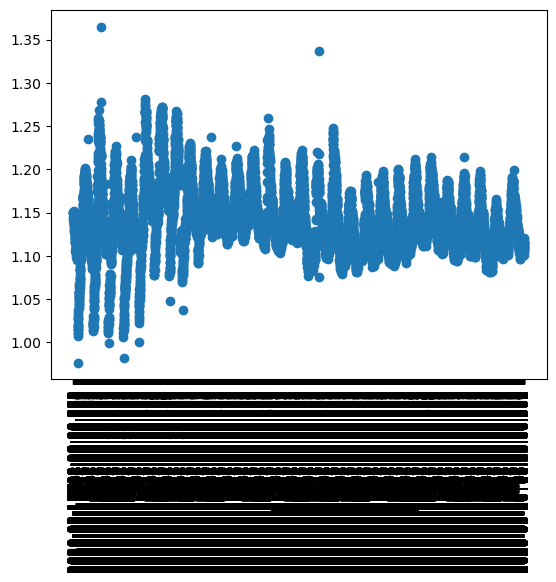

In [20]:
from matplotlib import pyplot as plt
%matplotlib inline 
# Have Matplotlib create vector (svg) instead of raster (png) images
#%config InlineBackend.figure_formats = ['svg'] 
#plt.figure()
plt.plot_date(*zip(*plotme))
plt.xticks(rotation=90)
plt.show()